look into reverse predictions - HLC -> features?

# Initialisations

In [5]:
import pandas as pd ; pd.set_option('display.max_columns', 500)
import numpy as np
from numpy import random ; random.RandomState(seed = 69)

from sklearn.model_selection import train_test_split

from sklearn import ensemble #gradientboosting
from sklearn import linear_model #lasso
from sklearn import tree #decision tree

from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
#joblib via sklearn.externals will be deprecated soon, so install and import joblib seperately
#import joblib
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import ipywidgets as widgets

In [2]:
#model = ensemble.GradientBoostingRegressor()

# Parameters we want to try
#param_grid = {
#    'n_estimators': [500, 1000, 2000],
#    'max_depth': [4, 6],
#    'min_samples_leaf': [3, 5, 9, 17],
#    'learning_rate': [0.1, 0.05, 0.02],
#    'max_features': [1.0, 0.3, 0.1],
#    'loss': ['ls', 'lad', 'huber']
#}

# Define the grid search we want to run. Run it with four cpus in parallel.
#gs_cv = GridSearchCV(model, param_grid, n_jobs=4)

# Run the grid search - on only the training data!
#gs_cv.fit(X_train, y_train)

# Print the parameters that gave us the best result!
#print(gs_cv.best_params_)

# After running a .....long..... time, the output will be something like
# {'loss': 'huber', 'learning_rate': 0.1, 'min_samples_leaf': 9, 'n_estimators': 3000, 'max_features': 0.1, 'max_depth': 6}


## Functions defined for this notebook

In [6]:
def gradient_boosting_show_results(X, y, 
                    function = ensemble.GradientBoostingRegressor, 
                    hp_dict = {'learning_rate': 0.02, 
                               'loss': 'huber', 
                               'max_depth': 6, 
                               'max_features': 0.1, 
                               'min_samples_leaf': 9, 
                               'n_estimators': 2000}):
    print('Features:', list(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    print('Train-Test Split Complete. \n Hyperparameters:')
    for i in hp_dict:
        print(i, hp_dict[i])
    model = ensemble.GradientBoostingRegressor(
        n_estimators=hp_dict['n_estimators'],
        learning_rate=hp_dict['learning_rate'],
        max_depth= hp_dict['max_depth'],
        min_samples_leaf = hp_dict['min_samples_leaf'],
        max_features=hp_dict['max_features'],
        loss=hp_dict['loss'])

    model.fit(X_train, y_train)
    print('Model trained')
    
    important_features_dict = {}
    for x,i in enumerate(model.feature_importances_):
        important_features_dict[x]=i


    important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
    
    importances = model.feature_importances_ # get np.array of importance values
  #  print("\n\n", importances, "\n\n")
    indices = np.argsort(importances)[::-1] # sort importance values descending order
    X_columns = X.columns
  #  # Print the feature ranking
  #  print("Feature ranking:")
#
  #  for f in range(X.shape[1]):
  #      print("%d. feature %s (%f)" % (f + 1, X_columns[f], importances[indices[f]]))
#
    # Plot the feature importances of the forest
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", align="center")
    plt.xticks(range(X.shape[1]), X_columns[important_features_list], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    pred_list = []
    for i in range(0, len(X)):
        prediction = model.predict([X.iloc[i]])
        pred_list.append(prediction)
    
    exp_calc_df = pd.DataFrame(y)
    exp_calc_df['Predicted'] = pred_list
    exp_calc_df.rename({0:'Experimental'}, inplace=True, axis=1)
    exp_calc_df.head()
    print('Training Score:\t', model.score(X_train, y_train))
    print('Testing Score:\t', model.score(X_test, y_test))
    
    print("$R^2$:\t", metrics.r2_score(y, pred_list))
    
    train_mse = mean_absolute_error(y_train, model.predict(X_train))
    print('Training error: \t', train_mse)
    test_mse = mean_absolute_error(y_test, model.predict(X_test))
    print('Testing error: \t', test_mse)
    
    save = input('Save model with joblib.dump? (y/n) \t')
    if save == 'y':
        filename = input('File name for model dump - extension and path added automatically :\t')
        name = "model_dump/" + filename + ".pkl"
        path = "C:\\Users\jtd1g16\Documents\Masters\Henry's Law\model_dump\\" + filename + '.pkl'
        print('Model saved: \t', path)
        joblib.dump(model, name)
        return exp_calc_df
    if save == 'n':
        print('Model not saved')
        return important_features_list, exp_calc_df

# ML on PCA result

Features: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
Train-Test Split Complete. 
 Hyperparameters:
learning_rate 0.02
loss huber
max_depth 6
max_features 0.1
min_samples_leaf 9
n_estimators 2000
Model trained


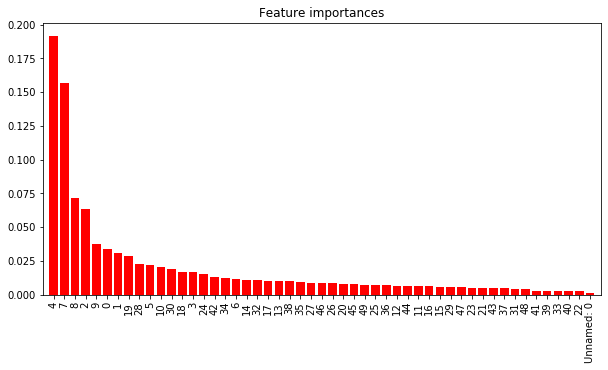

Training Score:	 0.9852503862607533
Testing Score:	 0.841005987171914
$R^2$:	 0.9382945123720151
Training error: 	 0.24571648232996127
Testing error: 	 1.7601974369869782
Save model with joblib.dump? (y/n) 	n
Model not saved


In [58]:
pca_data = pd.read_csv('pca_2_12.csv')
X = pca_data.drop('Constant', axis=1)
y = pca_data.Constant
importances, exp_calc_df_pca = gradient_boosting_show_results(X, y)

## Quick test on some curated data 18/11

Features: ['Hy', 'Ui', 'P_VSA_e_6', 'n135-Triazines', 'P_VSA_m_5', 'MLOGP2', 'SAtot', 'H-048', 'T(I..I)', 'Si', 'ISIZ', 'nHet', 'Xindex', 'P_VSA_e_3', 'nPyrazines', 'Sp', 'B03[C-C]', 'Yindex', 'Mv', 'B10[Br-Br]', 'CATS2D_09_DD', 'Varying_9', 'GATS7m', 'MATS7i', 'H%', 'B01[C-C]', 'B02[I-I]', 'GATS7v', 'TIE', 'nI', 'Me', 'MATS7v', 'nH', 'Uc', 'P_VSA_e_1', 'piPC02', 'F03[Br-Br]', 'GATS7e', 'C%', 'P_VSA_p_1', 'P_VSA_v_1', 'SdssS', 'CATS2D_08_LL', 'F02[I-I]', 'SpMax1_Bh(v)', 'F04[C-C]', 'F01[C-C]', 'NaaN', 'VvdwMG', 'T(N..Br)']
Train-Test Split Complete. 
 Hyperparameters:
learning_rate 0.02
loss huber
max_depth 6
max_features 0.1
min_samples_leaf 9
n_estimators 2000
Model trained


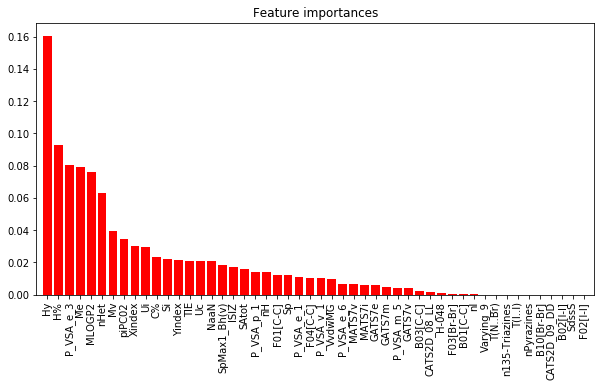

Training Score:	 0.9751519281285934
Testing Score:	 0.8124022426513384
$R^2$:	 0.9295378377027043
Training error: 	 0.5317978201574354
Testing error: 	 1.837606850593261
Save model with joblib.dump? (y/n) 	n
Model not saved


In [9]:
data = pd.read_csv('filtered_organics_desc.csv')
data.dropna(axis=0, inplace=True)
species = data.iloc[:, 1]
data.drop(['Unnamed: 0', '0'], axis=1, inplace=True)
data.head()
X = data[actually_important_features[0:50]]
y = data['Kh_first']
importances, exp_calc_df_1 = gradient_boosting_show_results(X, y)

In [8]:
features_list = pd.Series(list(data))
actually_important_features = features_list.iloc[importances][0:100]

2068

In [21]:
vary_list = ['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4', 'Varying_5',
             'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']
X_list = list(X) ; colour_list = []
for feature in X_list:
    colour_list.append("X." + str(feature))
@widgets.interact()
def plot_scatter_colour(colour_by = colour_list,
                        colour_type = ['rainbow', 'tab10']):
    fig = plt.figure(figsize=(15, 10))
    scatter = plt.scatter(list(exp_calc_df_1.Kh_first), list(exp_calc_df_1.Predicted),
                      c = eval(colour_by), cmap = colour_type)
    plt.colorbar()
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('Predited vs experimental log(H), coloured by {}'.format(colour_by))
    labels = ['{}'.format(i) for i in species]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.show()

interactive(children=(Dropdown(description='colour_by', options=('X.Hy', 'X.Ui', 'X.P_VSA_e_6', 'X.n135-Triazi…

# Testing gradientboosting on DRAGON descriptors

Features: ['Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me', 'Mp', 'Mi', 'nAT', 'nSK', 'nBT', 'nBO', 'nBM', 'SCBO', 'RBN', 'RBF', 'nDB', 'nTB', 'nAB', 'nH', 'nC', 'nN', 'nO', 'nP', 'nS', 'nF', 'nCL', 'nBR', 'nI', 'nHM', 'nHet', 'nX', 'H%', 'C%', 'N%', 'O%', 'X%', 'nCsp3', 'nCsp2', 'nCsp', 'P_VSA_m_1', 'P_VSA_m_2', 'P_VSA_m_3', 'P_VSA_m_4', 'P_VSA_m_5', 'P_VSA_v_1', 'P_VSA_v_2', 'P_VSA_v_3', 'P_VSA_v_4', 'P_VSA_e_1', 'P_VSA_e_2', 'P_VSA_e_3', 'P_VSA_e_4', 'P_VSA_e_5', 'P_VSA_e_6', 'P_VSA_p_1', 'P_VSA_p_2', 'P_VSA_p_3', 'P_VSA_p_4', 'P_VSA_i_1', 'P_VSA_i_2', 'P_VSA_i_3', 'P_VSA_i_4', 'P_VSA_s_5', 'P_VSA_s_6', 'nCp', 'nCs', 'nCt', 'nCq', 'nCrs', 'nCrt', 'nCrq', 'nCar', 'nCbH', 'nCb-', 'nCconj', 'nR=Cp', 'nR=Cs', 'nR=Ct', 'n=C=', 'nR#CH/X', 'nR#C-', 'nArNCO', 'nRSCN', 'nRNCS', 'nRCOOH', 'nArCOOH', 'nRCOOR', 'nArCOOR', 'nRCONH2', 'nArCONH2', 'nRCONHR', 'nArCONHR', 'nRCONR2', 'nArCONR2', 'nROCON', 'nArOCON', 'nRCOX', 'nArCOX', 'nRCOSR', 'nRCHO', 'nArCHO', 'nRCO', 'nArCO', 'nCONN', 'nC=O(O)2', 'nN=C-N<', '

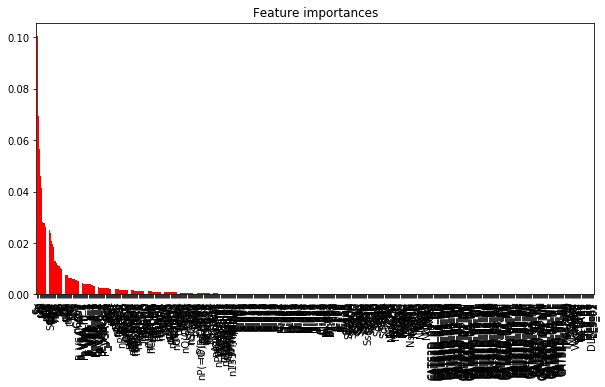

Training Score:	 0.9838527457514422
Testing Score:	 0.8802773630258752
$R^2$:	 0.9540159154327732
Training error: 	 0.6132393533436026
Testing error: 	 1.7575861249848597
Save model with joblib.dump? (y/n) 	n
Model not saved


In [25]:
dragon = pd.read_csv('DATA/dragon_descriptors_with_constants.csv')
dragon.drop('Unnamed: 0', axis=1, inplace=True)
X = dragon.drop('Constant', axis=1)
y = np.log(dragon.Constant)
exp_calc_df = gradient_boosting_show_results(X, y)

In [26]:
X_list = list(X) ; colour_list = []
for feature in X_list:
    colour_list.append("X." + str(feature))
@widgets.interact()
def plot_scatter_colour(colour_by = colour_list,
                        colour_type = ['rainbow', 'tab10']):
    fig = plt.figure(figsize=(15, 10))
    scatter = plt.scatter(exp_calc_df.Experimental, exp_calc_df.Predicted,
                      c = eval(colour_by), cmap = colour_type)
    plt.colorbar()
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('Predited vs experimental log(H), coloured by {}'.format(colour_by))
    labels = ['{}'.format(i) for i in species]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

interactive(children=(Dropdown(description='colour_by', options=('X.Sv', 'X.Se', 'X.Sp', 'X.Si', 'X.Mv', 'X.Me…

# Setting up features and constants to use in models
Read in only the organic set

In [6]:
data = pd.read_csv('DATA/organics.csv')
data1 = data.dropna(axis=0)

## Seperating small selection of molecules
Randomly selecting 13 molecules which all features are available for. This will leave 4000 species to train and test models on, then 13 'extra' molecules to compare my model to different models.

In [9]:
random_list = []
gen_rand = input('Generate new set of random molecules? (y/n):\t' )
if gen_rand == 'y':
    for i in range(0, 13):
        random_list.append(random.randint(0, 4014))
    random_list
    random_choice = data1.iloc[random_list]
    data_4000 = data1.drop(random_list, axis=0)
    print(random_choice.Species)
if gen_rand == 'n':
    print('Not generating new set.')
    print(random_choice.Species)

Generate new set of random molecules? (y/n):	y
3195                               pigment red 254
3078                   2-chloro-4-nitrobenzenamine
3210            1,1,1,3,3,3-hexafluoro-2-propanone
2209     1,1,2,2-tetrahydroperfluoro-1-hexadecanol
1572                          2,5-dimethylpyridine
2843                      2,4-dichlorodibenzofuran
3034      2,3-dichloro-5-(trichloromethyl)pyridine
3560                         methyl phenyl sulfide
454                             2-methyl-2-hexanol
3111                                  chlortoluron
3773    1,1,2,2-tetrachloroethanesulfenyl chloride
970            2-methylpropanoic acid, ethyl ester
438                            4-methyl-2-pentanol
Name: Species, dtype: object


## Seperate constants and features

In [10]:
constants = data_4000.Constant
features = data_4000.drop(['Constant', 'Species',
                       'SMILES', 'SMARTS',
                       'CAS'], axis=1)#remove constants from features df
random_constants = random_choice.Constant
random_features = random_choice.drop('Constant', axis=1)

## Feature selection
Change `X` and `y` to change features used

In [11]:
features['hba_hbd'] = features.hba + features.hbd

features_non_bond = features[['wt', 'logp', 'fraction_sp3',
                             'ali_homo_rings', 'ali_hetero_rings',
                             'amide_bonds',
                             'aro_homo_rings', 'aro_hetero_rings',
                             'hba', 'hbd', 'volume', 'tpsa',
                             'asph', 'ecce', 'isf', 'npr1', 'npr2', 
                             'pmi1', 'pmi2', 'pmi3', 'rog', 'si']]

features_bare = features[['wt', 'logp','hba', 'hbd', 'volume', 'tpsa']]
features_tf = features[['wt', 'logp', 'fraction_sp3',
             'hba', 'hbd', 'volume', 'tpsa']]
features_bare_notwt = features[['logp','hba_hbd', 'volume', 'tpsa']]

# select which feature set to use in models here
X = features_tf ; y = np.log(constants)

## Covariance matrix
Use this to determine the presence of multicollinearity in the features. This information is used in feature selection

In [ ]:
cov_matrix = X.cov(); cross_corr_list = []
for i in cov_matrix:
    feature1 = i
    for j in range(0, len(cov_matrix[feature1])):
        feature2 = cov_matrix.index[j]
        covariance = cov_matrix.loc[feature1, feature2]
        if covariance > 1 or covariance < -1:
            if feature1 != feature2:
                print(feature1, feature2, covariance)
                if (not (feature1+" "+feature2) in cross_corr_list):
                    if (not feature2+" "+feature1 in cross_corr_list):
                        cross_corr_list.append(feature1 +" "+ feature2)
cross_corr_list

In [ ]:
X.cov()

### Findings from covariance matrix
Some features are bound to be linked - eg (in an organics context) logp and volume will correlate - larger logp indicated higher lipophillicity, which is to in general to be expected for organic molecules with larger volume.

# `sklearn.ensemble` Gradient Boosting

Features: ['wt', 'logp', 'fraction_sp3', 'hba', 'hbd', 'volume', 'tpsa']
Train-Test Split Complete. 
 Hyperparameters:
learning_rate 0.02
loss huber
max_depth 6
max_features 0.1
min_samples_leaf 9
n_estimators 2000
Model trained


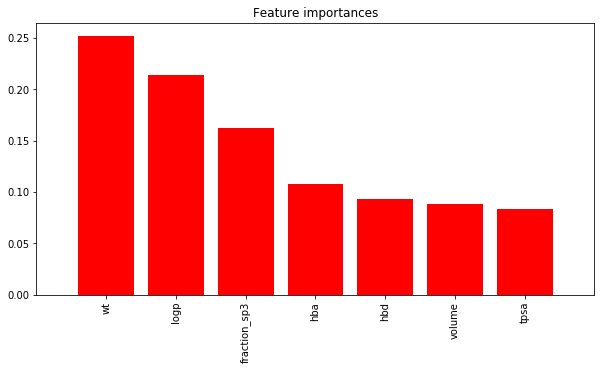

Training Score:	 0.9373280561321125
Testing Score:	 0.8329663169749364
$R^2$:	 0.9058480486458407
Training error: 	 1.3432856619788736
Testing error: 	 2.4786008446044145
Save model with joblib.dump? (y/n) 	n
Model not saved


In [12]:
exp_calc_df = gradient_boosting_show_results(X, y)

In [14]:
X_list = list(X) ; colour_list = []
for feature in X_list:
    colour_list.append("X." + str(feature))
@widgets.interact()
def plot_scatter_colour(colour_by = colour_list,
                        colour_type = ['tab10', 'rainbow']):
    fig = plt.figure(figsize=(10, 5))
    fig = plt.scatter(exp_calc_df.Experimental, exp_calc_df.Predicted,
                      c = eval(colour_by), cmap = colour_type)
    plt.colorbar()
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('Predited vs experimental $log(H)$')
    plt.show()

interactive(children=(Dropdown(description='colour_by', options=('X.wt', 'X.logp', 'X.fraction_sp3', 'X.hba', …

# `sklearn.tree` DecisionTreeRegressor
First test overfit the data by far - this was using the default hyperparameters, which do not limit the depth of trees/max samples per leaf node.
>`{'criterion': 'mse', 
'max_depth': None, 
'max_features': None,
'max_leaf_nodes': None, 
'min_impurity_decrease': 0.0,
'min_impurity_split': None, 
'min_samples_leaf': 1, 
'min_samples_split': 2,
'min_weight_fraction_leaf': 0.0, 
'presort': False, 
'random_state': None,
'splitter': 'best'}`

I'll tune some of the parameters and run a grid search if I can.

In [ ]:
dtr = tree.DecisionTreeRegressor(criterion = 'mse',
                                 max_depth = 4, 
                                 max_features = None, 
                                 max_leaf_nodes = 18, 
                                 min_impurity_decrease = 0.0, 
                                 min_impurity_split = None, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 min_weight_fraction_leaf = 0.0, 
                                 presort = False, 
                                 random_state = None, 
                                 splitter = 'best')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
dtr.fit(X_train, y_train)
print('Train score:\t', dtr.score(X_train, y_train))
print('Test score:\t ', dtr.score(X_test, y_test))
print('Params', dtr.get_params())

In [ ]:
importances = dtr.feature_importances_

indices = np.argsort(importances)[::-1]
X_columns = X.columns

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
            color="r", align="center")
plt.xticks(range(X.shape[1]), X_columns, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

X_list = list(X) ; colour_list = []
for feature in X_list:
    colour_list.append("X." + str(feature))
@widgets.interact()
def plot_scatter_colour(colour_by = colour_list,
                        colour_type = ['tab10', 'rainbow']):
    fig = plt.figure(figsize=(15, 10))
    fig = plt.scatter(exp_calc_df.Experimental, exp_calc_df.Predicted,
                      c = eval(colour_by), cmap = colour_type)
    plt.colorbar()
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('Predited vs experimental $log(H)$')
    plt.show()

# `sklearn.ensemble` [AdaBoostRegressor](scikit-learn.org/0.16/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)
Default params:
>`{'base_estimator': None, 
'learning_rate': 1.0, 
'loss': 'linear', 
'n_estimators': 50, 
'random_state': None}`

In [ ]:
ada = ensemble.AdaBoostRegressor(base_estimator = None, 
                                 learning_rate = 0.8, 
                                 loss = 'exponential', 
                                 n_estimators = 50, 
                                 random_state = None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ada.fit(X_train, y_train)
print('Train score:\t', ada.score(X_train, y_train))
print('Test score:\t ', ada.score(X_test, y_test))
print('Params', ada.get_params())

# `sklearn.linear_model` [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

In [ ]:
lasso = linear_model.Lasso(alpha=0.1, max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lasso.fit(X_train, y_train)
print('Train score:\t', lasso.score(X_train, y_train))
print('Test score:\t', lasso.score(X_test, y_test))
print('Params \n', lasso.get_params())
plt.scatter(exp_calc_df.Experimental, lasso.predict(X))
plt.xlabel('Experimental')
plt.ylabel('Predicted')

Not the best $R^2$

# `sklearn.linear_model` [Least angle regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lars.html#sklearn.linear_model.Lars)

In [ ]:
lars = linear_model.Lars(n_nonzero_coefs=np.inf)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lars.fit(X, y)
print('Train Score', lars.score(X_train, y_train))
print('Test score', lars.score(X_test, y_test))
print('Params', lars.get_params())
plt.scatter(exp_calc_df.Experimental, lars.predict(X))
plt.xlabel('Experimental')
plt.ylabel('Predicted')

Even worse $R^2$ than Lasso - moving on

# `sklearn.linear_model` [Bayesian Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)

In [ ]:
bayesian = linear_model.BayesianRidge()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
bayesian.fit(X_train, y_train)
print('Train score', bayesian.score(X_train, y_train))
print('Test score', bayesian.score(X_test, y_test))
print('Params', bayesian.get_params())
plt.scatter(exp_calc_df.Experimental, bayesian.predict(X))
plt.xlabel('Experimental')
plt.ylabel('Predicted')

# [Polynomial regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
Use some preprocessing with `sklearn.preprocessing` to transform features from $[x_1, x_2]$ to $[1, x_1, x_2, x_1^2, x_2^2, x_1x_2]$ etc. - this is still a linear model (linear combination of engineered features). Use `sklearn.pipeline.Pipeline` to streamline the process

In [ ]:
output_df = pd.DataFrame()
for feature in list(X):
    output_df = pd.concat([output_df, X[feature]], axis=1)
    df = pd.DataFrame(X[feature]).pow(2)
    df.rename({feature:'%s_2' % feature},
              inplace=True, axis=1)
    output_df = pd.concat([output_df, df], axis=1)

In [ ]:
exp_pred_df = gradient_boosting_show_results(output_df, np.log(constants))

In [ ]:
features_list = list(output_df); colour_list = []
for feature in features_list:
    colour_list.append("output_df." + str(feature))
@widgets.interact()
def plot_scatter_colour(colour_by = colour_list, colour_type = ['tab10', 'rainbow']):
    fig = plt.figure(figsize=(15, 10))
    fig = plt.scatter(exp_calc_df.Experimental, exp_calc_df.Predicted,
                      c = eval(colour_by), cmap = colour_type)
    plt.colorbar()
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('Predited vs experimental $log(H)$')
    plt.show()